In [1]:
from underlying import Underlying
from option import Option, Vanilla
from trader import Trader

import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
from quantile_hedging_calculator import *
import numpy as np
import pandas as pd

In [2]:
mu = 0.06
sigma =  0.2
r = 0
T = 1
X0 = 100
repeat = 1000
values_per_year = 250

## Full hedging - Vanilla Call

In [3]:
K = 80

In [4]:
underlying = Underlying(mu, sigma, r, values_per_year)

In [5]:
_, reality = underlying.simulate_P(repeat, T)

In [6]:
vanilla_call = Vanilla(underlying, K, T, True)

In [7]:
BS_price_call = vanilla_call.get_price(X0, 0)
BS_price_call

21.185929513210453

In [8]:
money_time_call = pd.DataFrame(np.zeros(reality.shape))
delta_time_call = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = BS_price_call)
    money, delta, _ = trader.simulate_hedging(vanilla_call, X0*reality.iloc[[i],:], update_freq = 1)
    money_time_call.loc[i] = money
    delta_time_call.loc[i] = delta

100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.31it/s]


Text(0.5, 1.0, 'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = -0.008, std = 0.219')

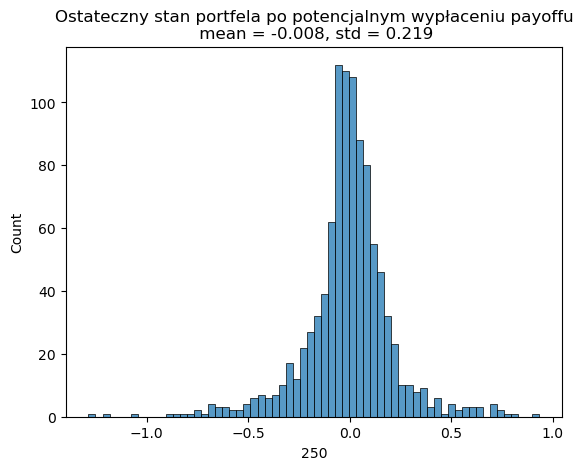

In [9]:
sb.histplot(money_time_call.iloc[:,-1]).set_title(f'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

## Full hedging - Vanilla Put

In [10]:
K = 120

In [11]:
underlying = Underlying(mu, sigma, r, values_per_year)

In [12]:
_, reality = underlying.simulate_P(repeat, T)

In [13]:
vanilla_put = Vanilla(underlying, K, T, False)

In [14]:
BS_price_put = vanilla_put.get_price(X0, 0)
BS_price_put

22.14729881057815

In [15]:
money_time_put = pd.DataFrame(np.zeros(reality.shape))
delta_time_put = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = BS_price_put)
    money, delta, _ = trader.simulate_hedging(vanilla_put, X0*reality.iloc[[i],:], update_freq = 1)
    money_time_put.loc[i] = money
    delta_time_put.loc[i] = delta

100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 22.08it/s]


Text(0.5, 1.0, 'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = -0.005, std = 0.407')

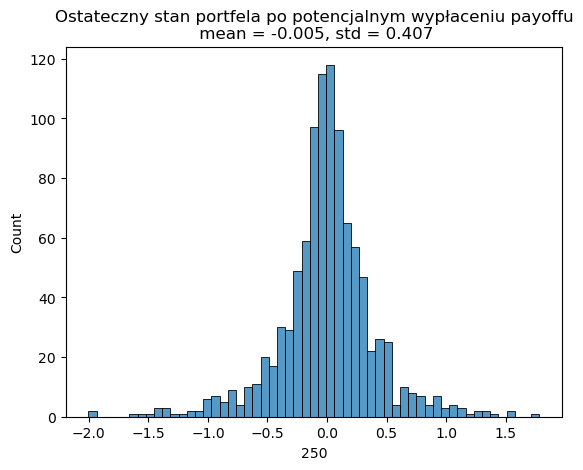

In [16]:
sb.histplot(money_time_put.iloc[:,-1]).set_title(f'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

## Quantile hedging with half of required initial capital- Vanilla Call

In [17]:
K = 80

In [18]:
underlying = Underlying(mu, sigma, r, values_per_year)

In [19]:
_, reality = underlying.simulate_P(repeat, T)

In [20]:
V0 = BS_price_call / 2

In [21]:
money_time_call_full = pd.DataFrame(np.zeros(reality.shape))
delta_time_call_full = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = V0)
    money, delta, _ = trader.simulate_hedging(vanilla_call, X0*reality.iloc[[i],:], update_freq = 1)
    money_time_call_full.loc[i] = money
    delta_time_call_full.loc[i] = delta

100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.64it/s]


In [22]:
vanilla_call = Vanilla(underlying, K, T, True)

In [23]:
money_time_call = pd.DataFrame(np.zeros(reality.shape))
delta_time_call = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = V0)
    money, delta, objective_func = trader.simulate_hedging(vanilla_call, X0*reality.iloc[[i],:], update_freq = 1, mode = 'quantile_traded')
    money_time_call.loc[i] = money
    delta_time_call.loc[i] = delta
print(f'Success probability with initial capital={V0:.2f} is: {objective_func[0]:.4f}')
print(f'Success ratio with initial capital={V0:.2f} is: {objective_func[1]:.4f}')

100%|███████████████████████████████████████| 1000/1000 [05:16<00:00,  3.16it/s]

Success probability with initial capital=10.59 is: 0.6278
Success ratio with initial capital=10.59 is: 0.8802


(0.0, 250.0)

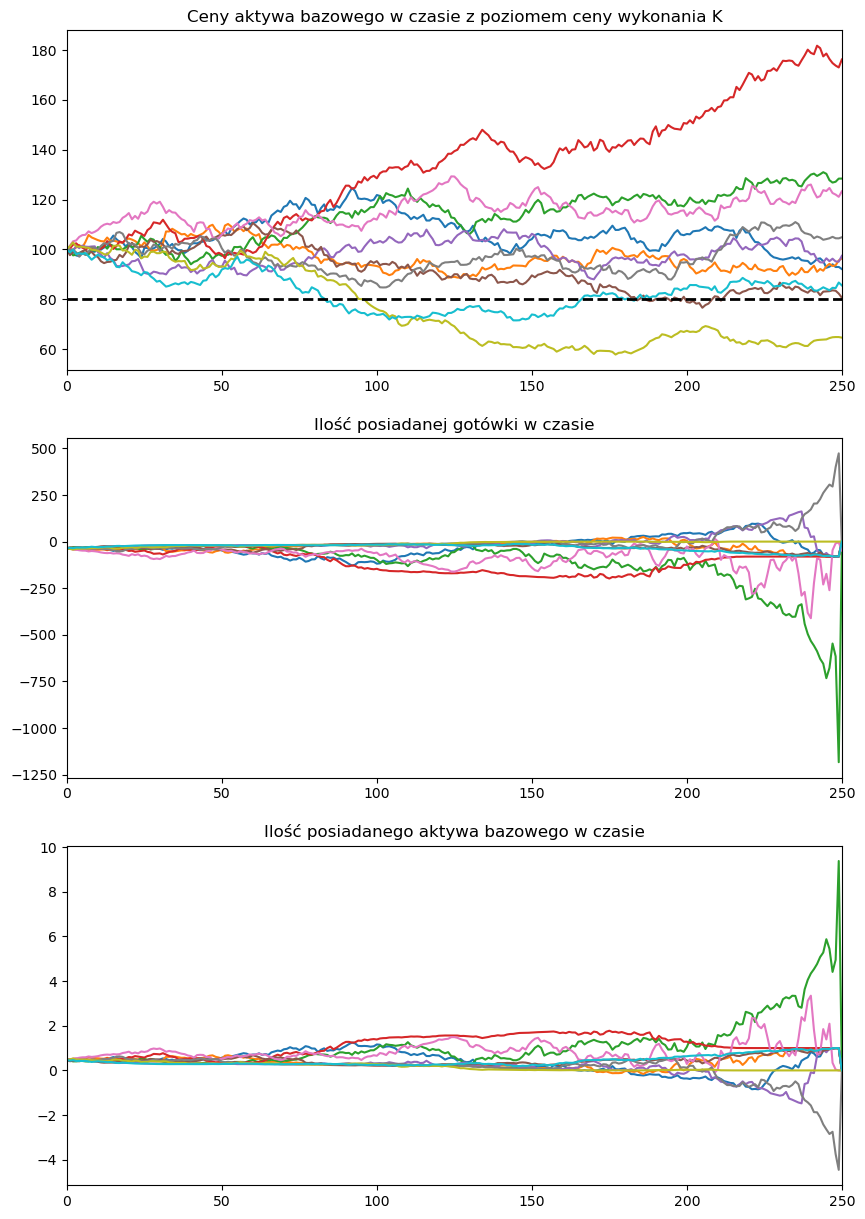

In [24]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
indices = [(X0 * reality).iloc[:,-1].idxmax(),(X0 * reality).iloc[:,-1].idxmin(), abs((X0 * reality).iloc[:,-1] - K).idxmin()]
(X0*reality.iloc[indices,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[indices,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[indices,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

[(-60.51031899256772, 17.895282047275856),
 Text(0.5, 1.0, 'Dopasowany do V0 hedging kwantylowy\n mean = -13.152, std = 16.644')]

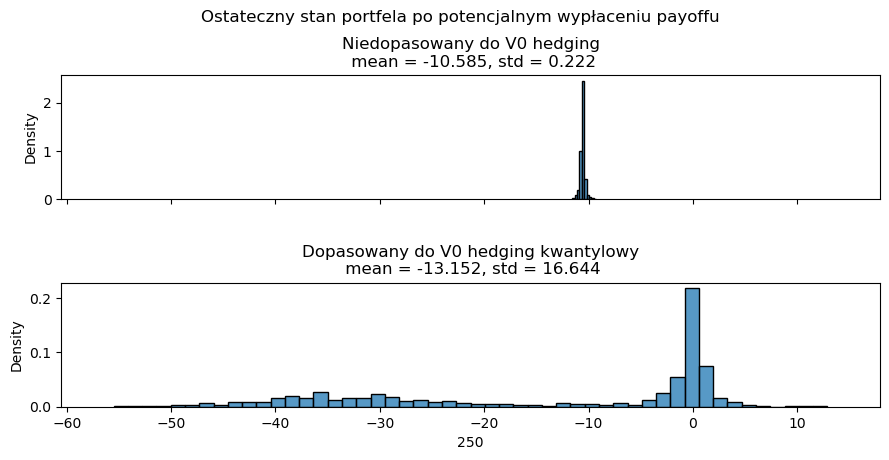

In [25]:
fig, axs = plt.subplots(2, 1, figsize = (10, 5), sharex = True)
fig.tight_layout(pad=5.0)
plt.suptitle('Ostateczny stan portfela po potencjalnym wypłaceniu payoffu')
sb.histplot(money_time_call_full.iloc[:,-1], ax = axs[0], bins = 10, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Niedopasowany do V0 hedging\n mean = {money_time_call_full.iloc[:,-1].mean():.3f}, std = {money_time_call_full.iloc[:,-1].std():.3f}')
sb.histplot(money_time_call.iloc[:,-1], ax = axs[1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

Text(0.5, 1.0, 'Ostateczny stan portfela- wszystkie symulacje')

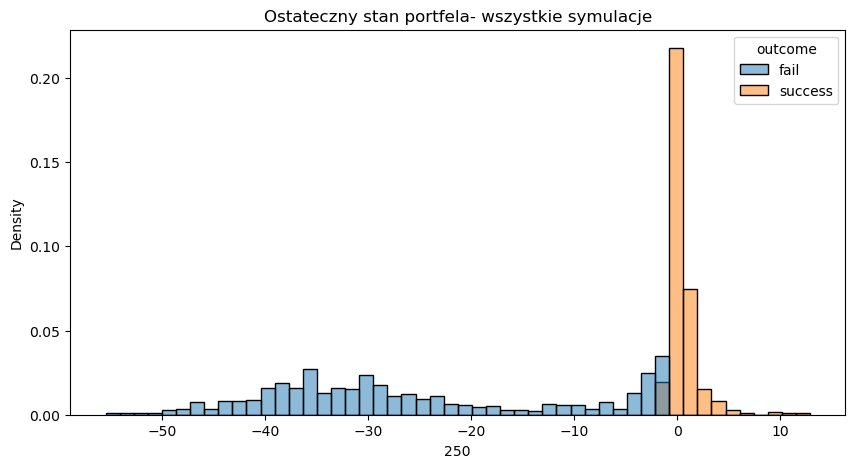

In [26]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying.values_per_year * T], bins = 50, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [27]:
money_time_call_outcome[['outcome',underlying.values_per_year * T]].groupby('outcome').describe()

250                                                         \
         count       mean        std        min        25%        50%   
outcome                                                                 
fail     532.0 -25.169601  14.493268 -55.510319 -36.333815 -29.307938   
success  468.0   0.509162   1.481695  -1.057311  -0.257516   0.170793   

                               
               75%        max  
outcome                        
fail    -11.377419  -1.077952  
success   0.773240  12.895282

Text(0.5, 1.0, 'Ostateczny payoff opcji (wszystkie symulacje)- histogram')

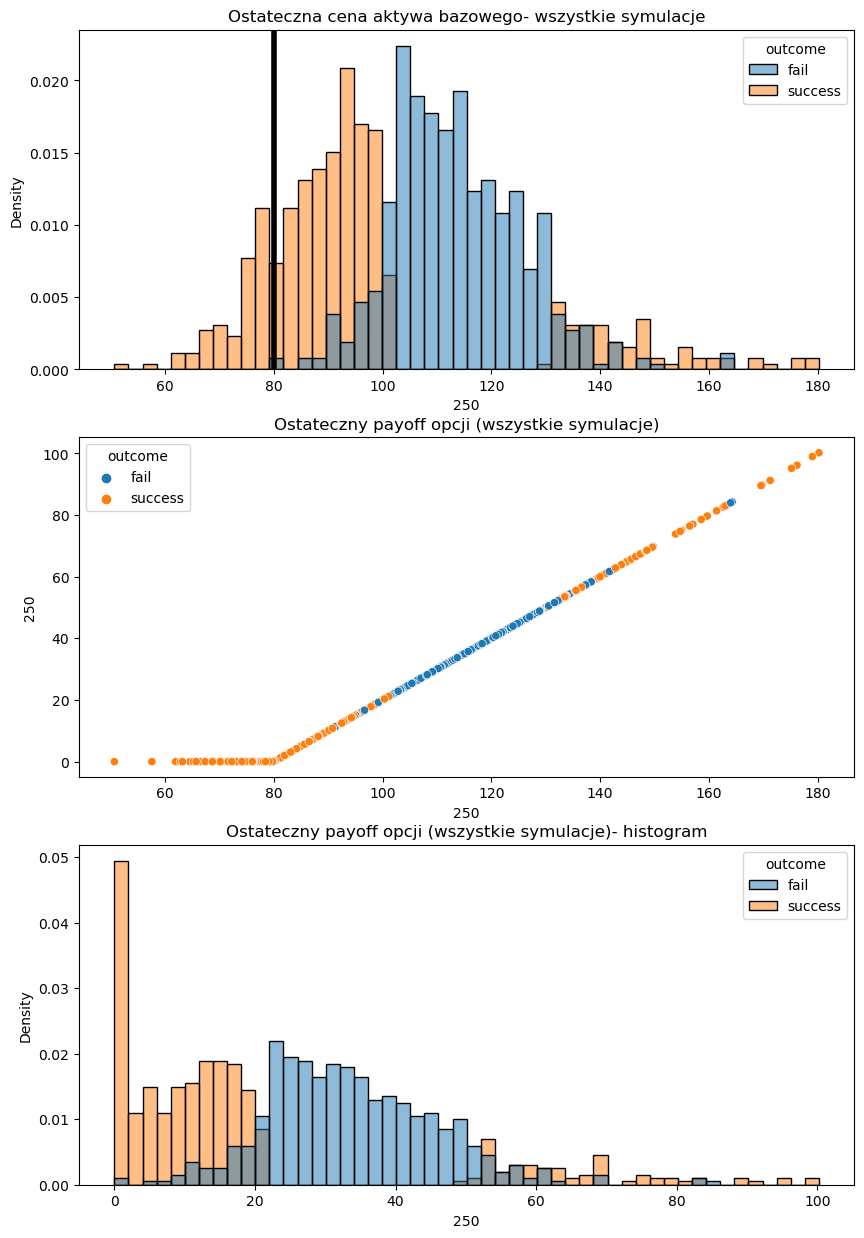

In [28]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
sb.histplot(ax = axs[0], x = (X0*reality)[underlying.values_per_year * T], hue = money_time_call_outcome['outcome'], bins = 50, stat = 'density').set_title('Ostateczna cena aktywa bazowego- wszystkie symulacje')
axs[0].axvline(K, color = 'black', lw = 4)
sb.scatterplot(ax = axs[1], x = (X0*reality).iloc[:,-1], y = np.maximum((X0*reality)[underlying.values_per_year * T] - K,0), hue = money_time_call_outcome['outcome']).set_title('Ostateczny payoff opcji (wszystkie symulacje)')
sb.histplot(ax = axs[2], x = np.maximum((X0*reality)[underlying.values_per_year * T] - K,0), hue = money_time_call_outcome['outcome'], bins = 50, stat = 'density').set_title('Ostateczny payoff opcji (wszystkie symulacje)- histogram')

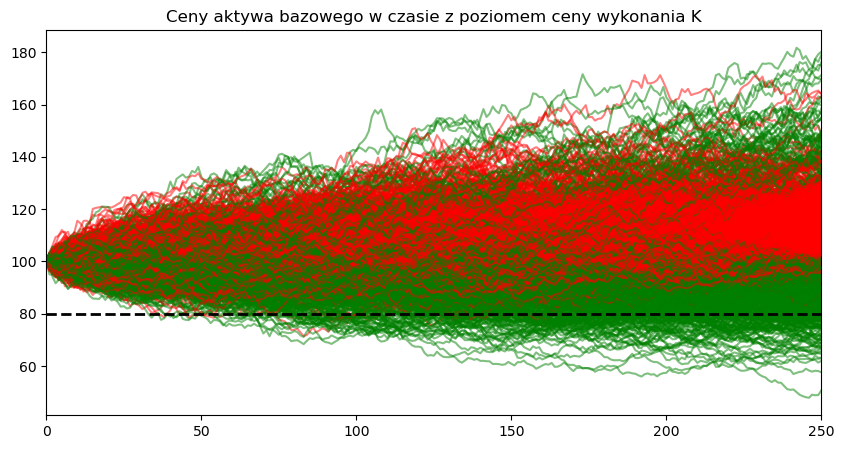

In [29]:
fig, axs = plt.subplots(1, 1, figsize = (10, 5))
(X0*reality).T.plot.line(ax = axs, alpha = 0.5, legend = False, color = money_time_call_outcome.apply(lambda row: 'green' if row['outcome'] == 'success' else 'red', axis = 1), title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs.set_xlim([0,values_per_year])
axs.axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)

## Quantile hedging with half of required initial capital- Vanilla Put

In [30]:
K = 120

In [31]:
underlying = Underlying(mu, sigma, r, values_per_year)

In [32]:
_, reality = underlying.simulate_P(repeat, T)

In [33]:
V0 = BS_price_put / 2

In [34]:
money_time_put_full = pd.DataFrame(np.zeros(reality.shape))
delta_time_put_full = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = V0)
    money, delta, _ = trader.simulate_hedging(vanilla_put, X0*reality.iloc[[i],:], update_freq = 1)
    money_time_put_full.loc[i] = money
    delta_time_put_full.loc[i] = delta

100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 22.12it/s]


In [35]:
vanilla_put = Vanilla(underlying, K, T, False)

In [36]:
money_time_put = pd.DataFrame(np.zeros(reality.shape))
delta_time_put = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = V0)
    money, delta, objective_func = trader.simulate_hedging(vanilla_put, X0*reality.iloc[[i],:], update_freq = 1, mode = 'quantile_traded')
    money_time_put.loc[i] = money
    delta_time_put.loc[i] = delta
print(f'Success probability with initial capital={V0:.2f} is: {objective_func[0]:.4f}')
print(f'Success ratio with initial capital={V0:.2f} is: {objective_func[1]:.4f}')

100%|███████████████████████████████████████| 1000/1000 [05:12<00:00,  3.20it/s]

Success probability with initial capital=11.07 is: 0.7301
Success ratio with initial capital=11.07 is: 0.9068


(0.0, 250.0)

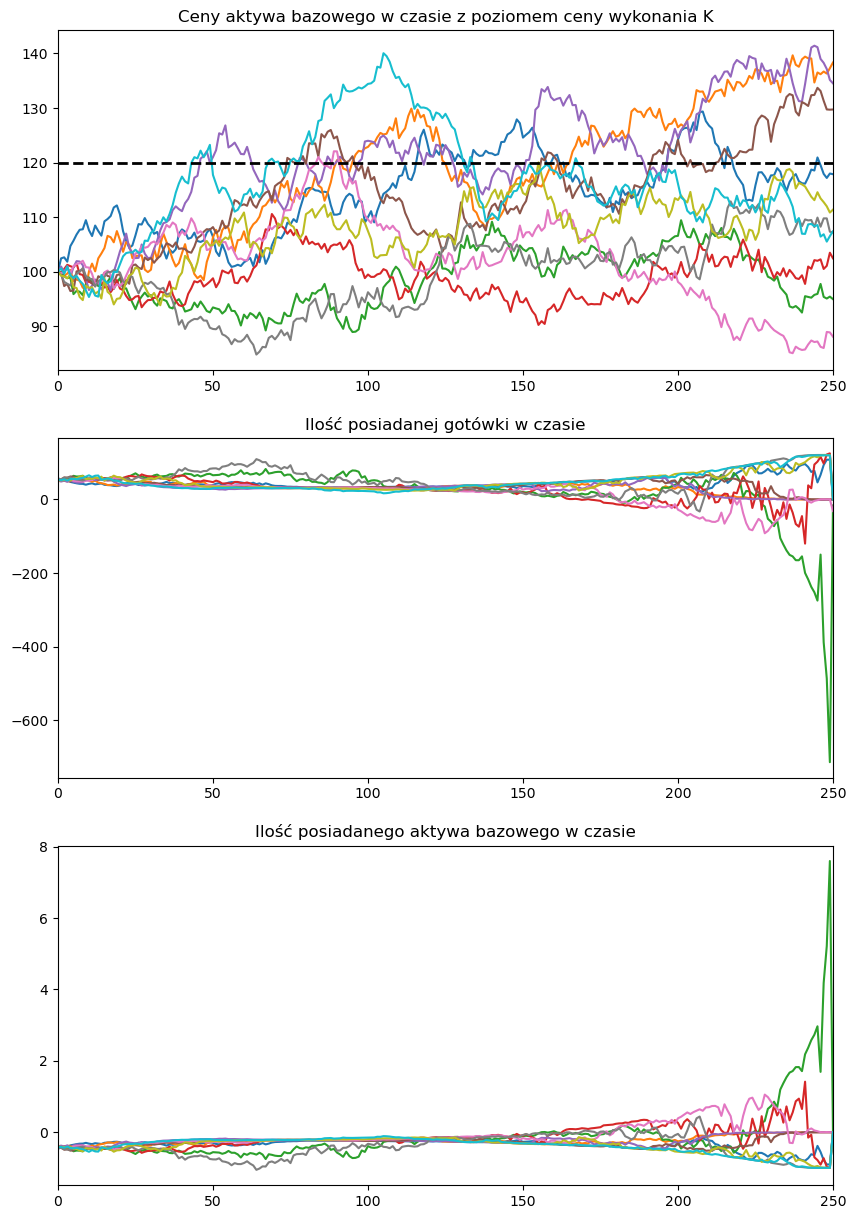

In [37]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
indices = [(X0 * reality).iloc[:,-1].idxmax(),(X0 * reality).iloc[:,-1].idxmin(), abs((X0 * reality).iloc[:,-1] - K).idxmin()]
(X0*reality.iloc[indices,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[indices,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[indices,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

[(-58.95961305503586, 21.267299678488314),
 Text(0.5, 1.0, 'Dopasowany do V0 hedging kwantylowy\n mean = -7.854, std = 13.866')]

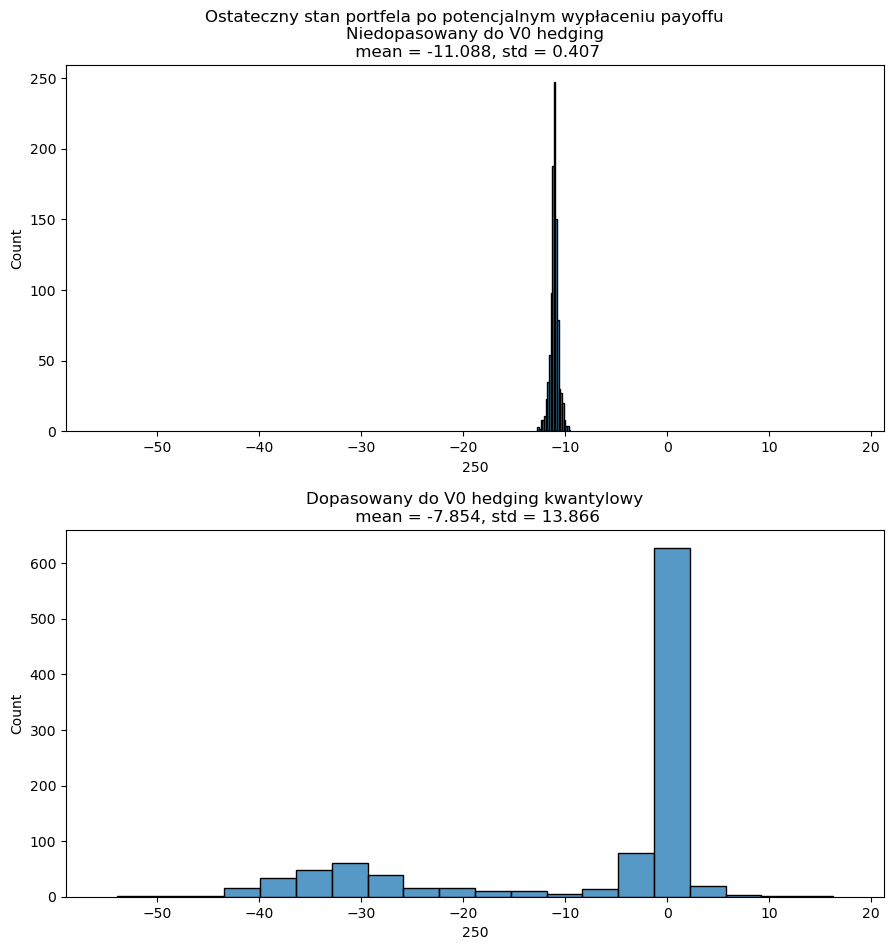

In [38]:
fig, axs = plt.subplots(2, 1, figsize = (10, 10))
fig.tight_layout(pad=5.0)
plt.suptitle('Ostateczny stan portfela po potencjalnym wypłaceniu payoffu')
sb.histplot(money_time_put_full.iloc[:,-1], ax = axs[0], bins = 20).set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Niedopasowany do V0 hedging\n mean = {money_time_put_full.iloc[:,-1].mean():.3f}, std = {money_time_put_full.iloc[:,-1].std():.3f}')
sb.histplot(money_time_put.iloc[:,-1], ax = axs[1], bins = 20).set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

Text(0.5, 1.0, 'Ostateczny stan portfela- wszystkie symulacje')

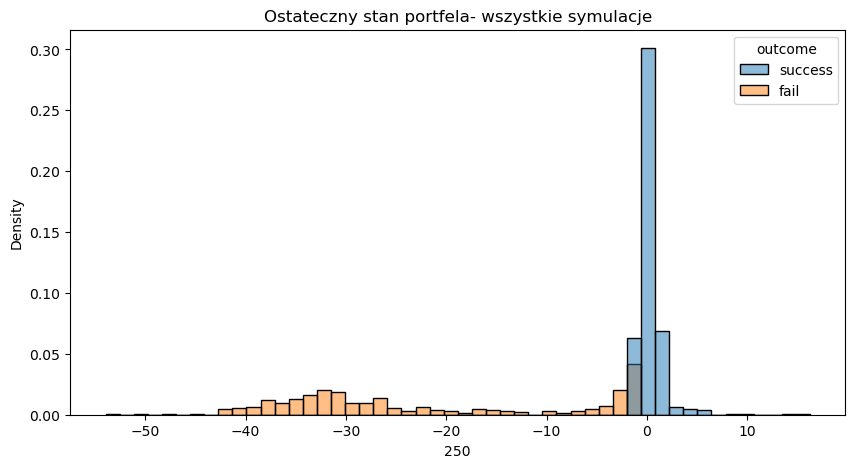

In [39]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying.values_per_year * T], bins = 50, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [40]:
money_time_put_outcome[['outcome',underlying.values_per_year * T]].groupby('outcome').describe()

250                                                         \
         count       mean        std        min        25%        50%   
outcome                                                                 
fail     366.0 -22.016024  14.335337 -53.959613 -33.422434 -27.165013   
success  634.0   0.322239   1.415541  -1.106772  -0.375798   0.062227   

                              
              75%        max  
outcome                       
fail    -3.922775  -1.108709  
success  0.589718  16.267300

Text(0.5, 1.0, 'Ostateczny payoff opcji (wszystkie symulacje)- histogram')

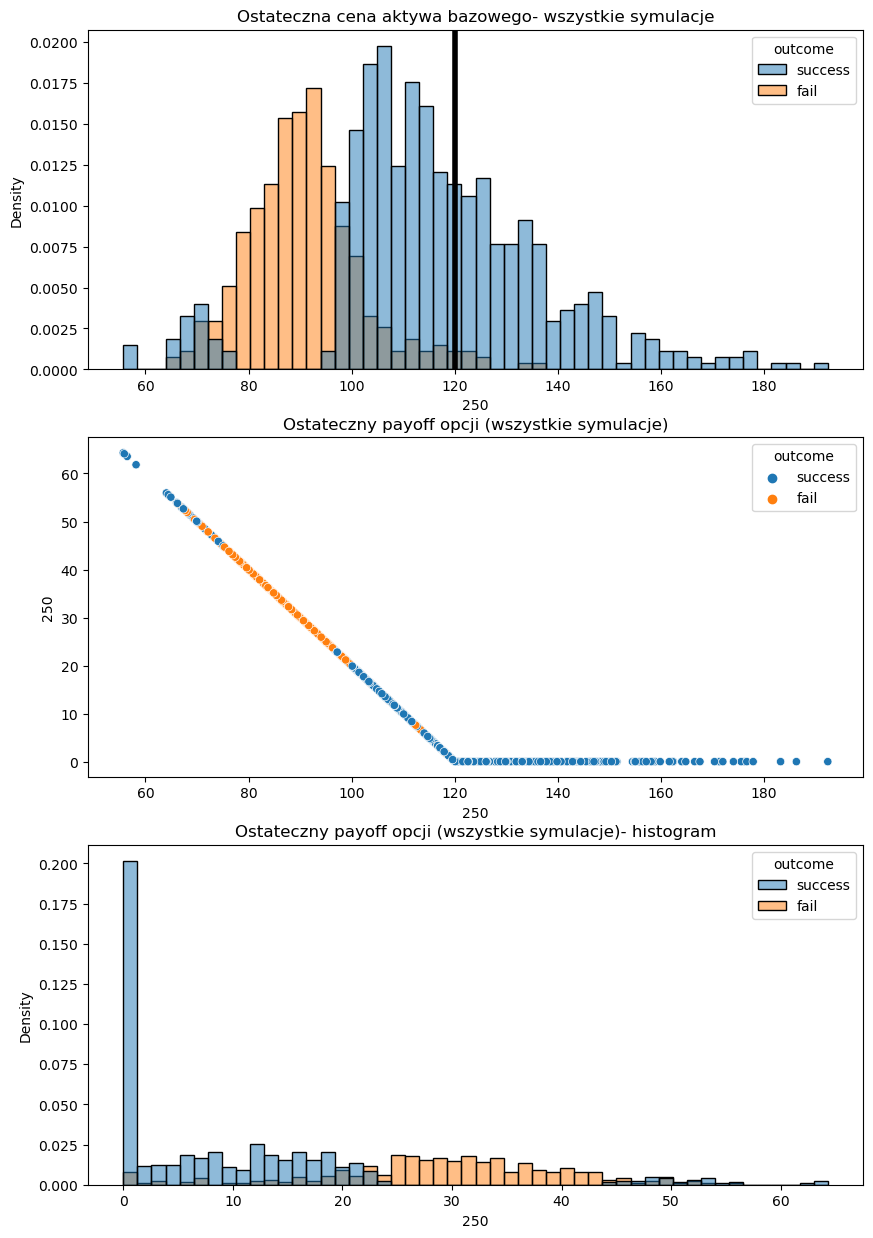

In [41]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
sb.histplot(ax = axs[0], x = (X0*reality)[underlying.values_per_year * T], hue = money_time_put_outcome['outcome'], bins = 50, stat = 'density').set_title('Ostateczna cena aktywa bazowego- wszystkie symulacje')
axs[0].axvline(K, color = 'black', lw = 4)
sb.scatterplot(ax = axs[1], x = (X0*reality).iloc[:,-1], y = np.maximum(K - (X0*reality)[underlying.values_per_year * T],0), hue = money_time_put_outcome['outcome']).set_title('Ostateczny payoff opcji (wszystkie symulacje)')
sb.histplot(ax = axs[2], x = np.maximum(K - (X0*reality)[underlying.values_per_year * T],0), hue = money_time_put_outcome['outcome'], bins = 50, stat = 'density').set_title('Ostateczny payoff opcji (wszystkie symulacje)- histogram')

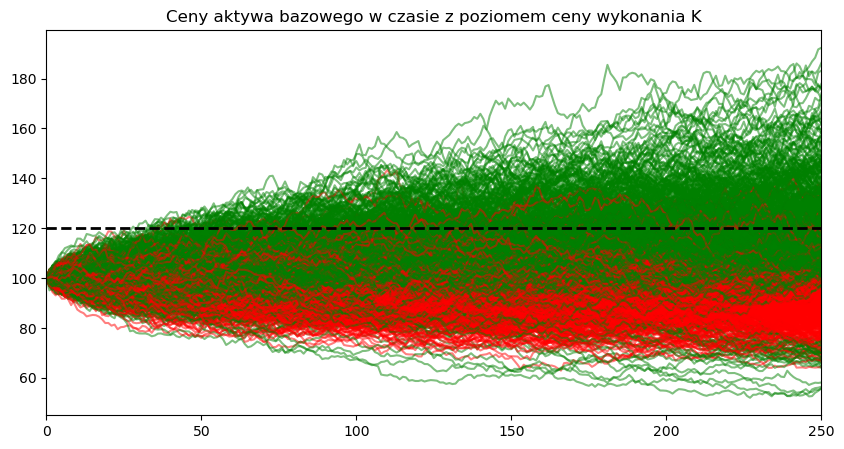

In [42]:
fig, axs = plt.subplots(1, 1, figsize = (10, 5))
(X0*reality).T.plot.line(ax = axs, alpha = 0.5, legend = False, color = money_time_put_outcome.apply(lambda row: 'green' if row['outcome'] == 'success' else 'red', axis = 1), title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs.set_xlim([0,values_per_year])
axs.axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)

## Tests on modified payoff properties

### Vanilla call

In [43]:
K = 80
vanilla_call = Vanilla(underlying, K, T, True)

In [44]:
payoff_func_v0, objective_func, cs = payoff_from_v0(vanilla_call, BS_price_call/2, X0)
print(f'Success prob for V0={BS_price_call/2:.2f}: {objective_func[0]:.5f}')
print(f'Success ratio for V0={BS_price_call/2:.2f}: {objective_func[1]:.5f}')
payoff_func_prob, success_V0, _ = payoff_from_prob(vanilla_call, objective_func[0], X0)
print(f'Proper V0 for success prob={objective_func[0]:.2f}: {success_V0:.2f}')

Success prob for V0=10.59: 0.61990
Success ratio for V0=10.59: 0.87773
Proper V0 for success prob=0.62: 10.30


In [45]:
W, X = vanilla_call.underlying.simulate_P(10000, T=vanilla_call.T)

Text(0.5, 0.98, "Simulations final value and option's modified payoffs together with K and c boundaries")

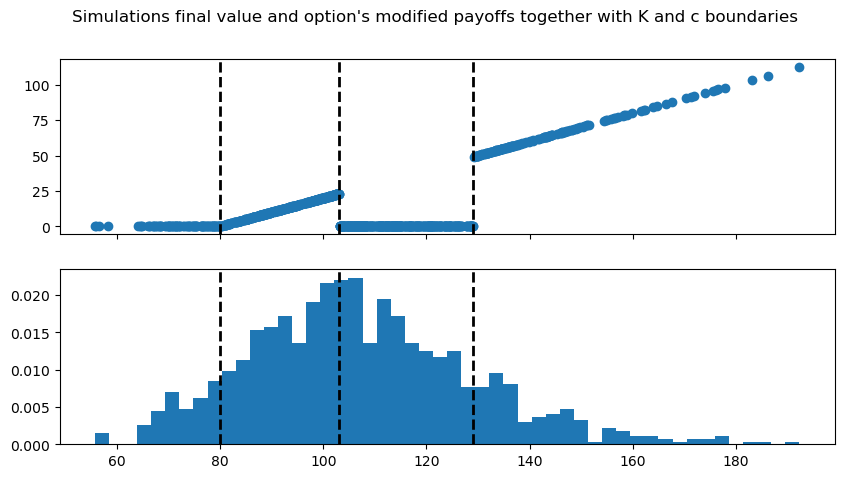

In [46]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (10, 5))
axs[0].scatter(X0*reality.iloc[:,-1], payoff_func_v0(X0*reality))
axs[0].axvline(K, color = 'black', linestyle = '--', lw = 2)
for c in cs:
    if c > 0:
        axs[0].axvline(c, color = 'black', linestyle = '--', lw = 2)
axs[1].hist(X0*reality.iloc[:,-1], bins = 50, density = True)
axs[1].axvline(K, color = 'black', linestyle = '--', lw = 2)
for c in cs:
    if c > 0:
        axs[1].axvline(c, color = 'black', linestyle = '--', lw = 2)
plt.suptitle("Simulations final value and option's modified payoffs together with K and c boundaries")

### Vanilla put

In [47]:
K = 120
vanilla_put = Vanilla(underlying, K, T, False)

In [48]:
payoff_func_v0, objective_func, cs = payoff_from_v0(vanilla_put, BS_price_put/2, X0)
print(f'Success prob for V0={BS_price_put/2:.2f}: {objective_func[0]:.5f}')
print(f'Success ratio for V0={BS_price_put/2:.2f}: {objective_func[1]:.5f}')
payoff_func_prob, success_V0, _ = payoff_from_prob(vanilla_put, objective_func[0], X0)
print(f'Proper V0 for success prob={objective_func[0]:.2f}: {success_V0:.2f}')

Success prob for V0=11.07: 0.73680
Success ratio for V0=11.07: 0.90829
Proper V0 for success prob=0.74: 11.17


Text(0.5, 0.98, "Simulations final value and option's modified payoffs together with K and c boundaries")

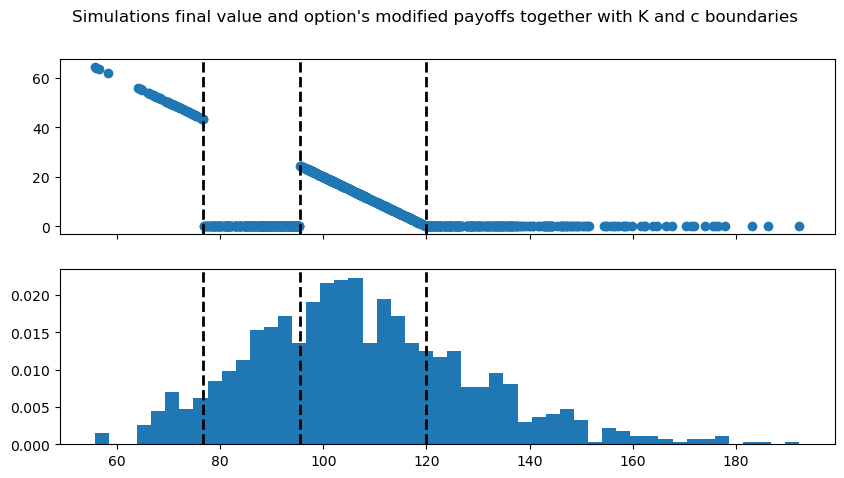

In [49]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (10, 5))
axs[0].scatter(X0*reality.iloc[:,-1], payoff_func_v0(X0*reality))
axs[0].axvline(K, color = 'black', linestyle = '--', lw = 2)
for c in cs:
    if c > 0:
        axs[0].axvline(c, color = 'black', linestyle = '--', lw = 2)
axs[1].hist(X0*reality.iloc[:,-1], bins = 50, density = True)
axs[1].axvline(K, color = 'black', linestyle = '--', lw = 2)
for c in cs:
    if c > 0:
        axs[1].axvline(c, color = 'black', linestyle = '--', lw = 2)
plt.suptitle("Simulations final value and option's modified payoffs together with K and c boundaries")

## Sensivity analysis on $\alpha$ vs success probability

### Vanilla call

4it [00:57, 14.44s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla call\nalpha level vs objective functions values')

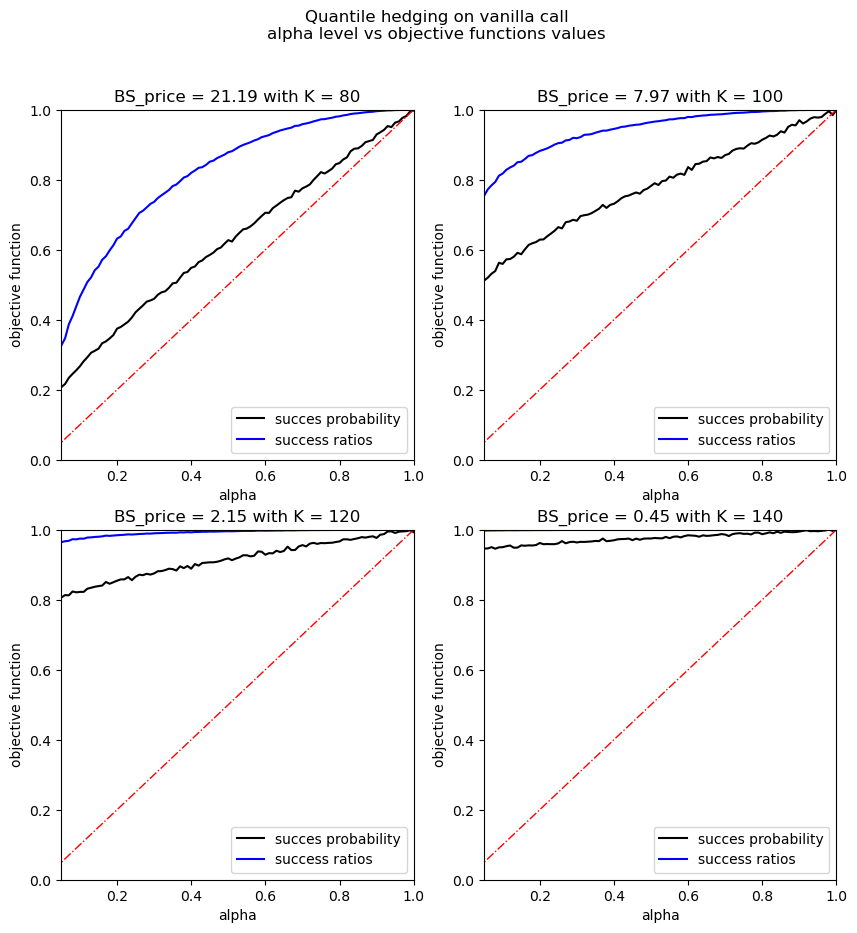

In [50]:
Ks = [80, 100, 120, 140]
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for num, K in tqdm(enumerate(Ks)):
    vanilla_call = Vanilla(underlying, K, T, True)
    BS_price = vanilla_call.get_price(X0, 0)
    alphas = np.arange(5,101,1)/100
    probs = []
    ratios = []
    for a in alphas:
        _, objective_func, _ = payoff_from_v0(vanilla_call, a * BS_price, X0)
        probs.append(objective_func[0])
        ratios.append(objective_func[1])
    axs[num//2, num%2].plot(alphas, probs, color = 'black')
    axs[num//2, num%2].plot(alphas, ratios, color = 'blue')
    axs[num//2, num%2].legend(['succes probability', 'success ratios'])
    axs[num//2, num%2].plot([0,1],[0,1], color = 'red', lw = 1, linestyle='-.')
    axs[num//2, num%2].set_title(f'BS_price = {BS_price:.2f} with K = {K}')
    axs[num//2, num%2].set_xlabel('alpha')
    axs[num//2, num%2].set_ylabel('objective function')
    axs[num//2, num%2].set_xlim([0.05,1])
    axs[num//2, num%2].set_ylim([0,1])
plt.suptitle('Quantile hedging on vanilla call\nalpha level vs objective functions values')

4it [1:09:33, 1043.44s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla call\nfinal simulation values')

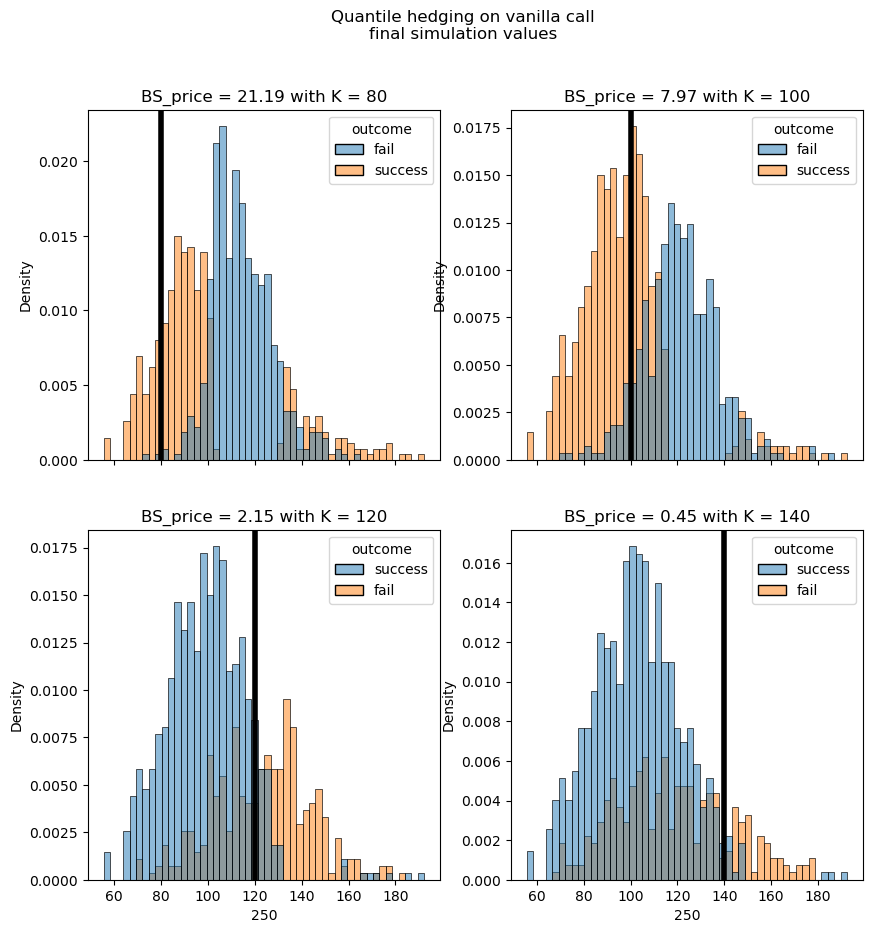

In [51]:
Ks = [80, 100, 120, 140]
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex = True)
for num, K in tqdm(enumerate(Ks)):
    vanilla_call = Vanilla(underlying, K, T, True)
    BS_price = vanilla_call.get_price(X0, 0)
    V0 = 0.5 * BS_price
    money_time_call = pd.DataFrame(np.zeros(reality.shape))
    delta_time_call = pd.DataFrame(np.zeros(reality.shape))
    for i in range(repeat):
        trader = Trader(initial_capital = V0)
        money, delta, _ = trader.simulate_hedging(vanilla_call, X0*reality.iloc[[i],:], update_freq = 1, mode = 'quantile_traded')
        money_time_call.loc[i] = money
        delta_time_call.loc[i] = delta
    money_time_call_outcome = money_time_call.copy()
    money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
    sb.histplot(ax = axs[num//2, num%2], x = (X0*reality)[underlying.values_per_year * T], hue = money_time_call_outcome['outcome'], bins = 50, stat = 'density').set_title(f'BS_price = {BS_price:.2f} with K = {K}')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla call\nfinal simulation values')

8it [00:12,  1.53s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla call\nmodified payoff')

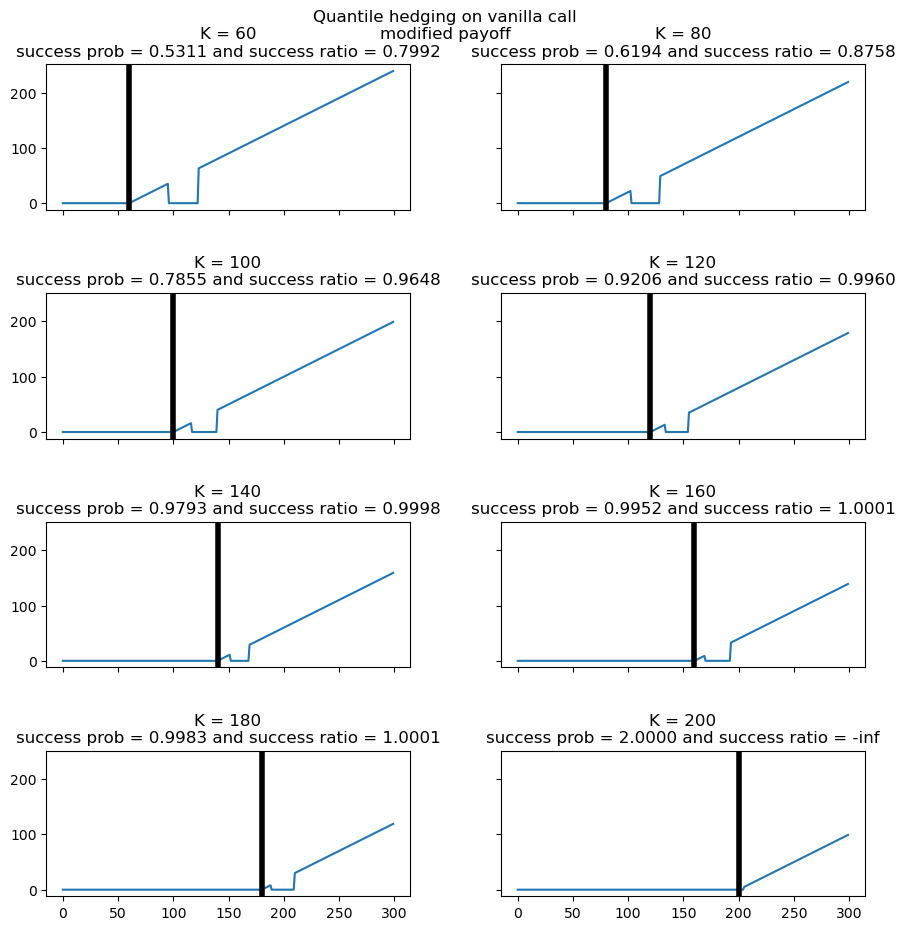

In [52]:
Ks = [60, 80, 100, 120, 140, 160, 180, 200]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharex = True, sharey = True)
fig.tight_layout(pad=5.0)
for num, K in tqdm(enumerate(Ks)):
    vanilla_call = Vanilla(underlying, K, T, True)
    BS_price = vanilla_call.get_price(X0, 0)
    V0 = 0.5 * BS_price
    payoff_func, objective_func, _ = payoff_from_v0(vanilla_call, V0, X0)
    axs[num//2, num%2].plot(X, payoff_func(X))
    axs[num//2, num%2].set_title(f'K = {K}\nsuccess prob = {objective_func[0]:.4f} and success ratio = {objective_func[1]:.4f}')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla call\nmodified payoff')

8it [00:11,  1.41s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla call\nmodified payoff')

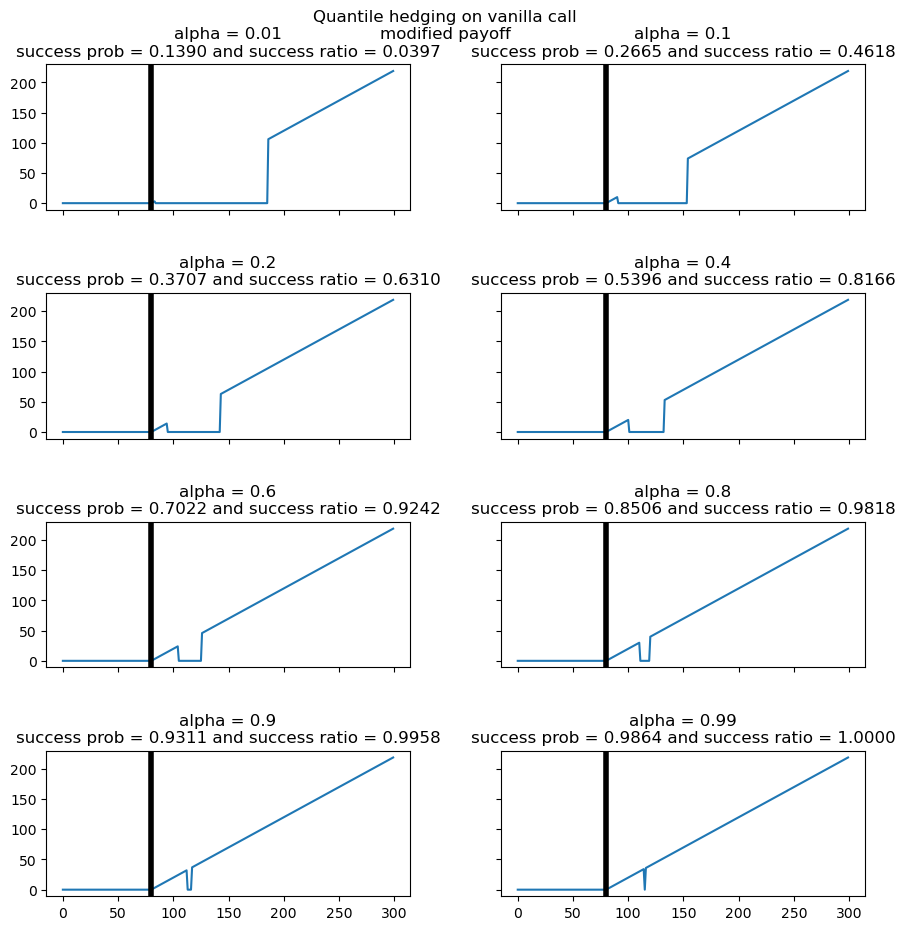

In [53]:
alphas = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharex = True, sharey = True)
fig.tight_layout(pad=5.0)
for num, a in tqdm(enumerate(alphas)):
    vanilla_call = Vanilla(underlying, 80, T, True)
    BS_price = vanilla_call.get_price(X0, 0)
    V0 = a * BS_price
    payoff_func, objective_func, _ = payoff_from_v0(vanilla_call, V0, X0)
    axs[num//2, num%2].plot(X, payoff_func(X))
    axs[num//2, num%2].set_title(f'alpha = {a}\nsuccess prob = {objective_func[0]:.4f} and success ratio = {objective_func[1]:.4f}')
    axs[num//2, num%2].axvline(80, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla call\nmodified payoff')

8it [00:11,  1.41s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla call\nmodified payoff')

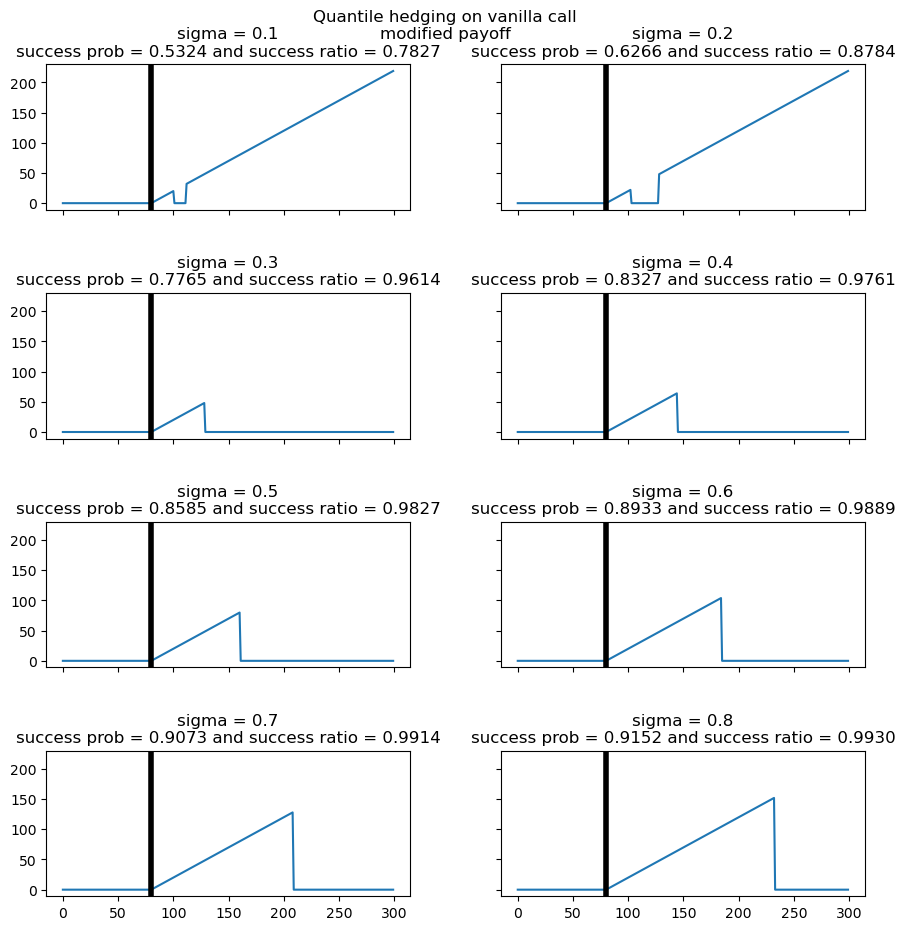

In [54]:
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharex = True, sharey = True)
fig.tight_layout(pad=5.0)
for num, s in tqdm(enumerate(sigmas)):
    underlying = Underlying(mu, s, r, values_per_year)
    vanilla_call = Vanilla(underlying, 80, T, True)
    BS_price = vanilla_call.get_price(X0, 0)
    V0 = BS_price / 2
    payoff_func, objective_func, _ = payoff_from_v0(vanilla_call, V0, X0)
    axs[num//2, num%2].plot(X, payoff_func(X))
    axs[num//2, num%2].set_title(f'sigma = {s}\nsuccess prob = {objective_func[0]:.4f} and success ratio = {objective_func[1]:.4f}')
    axs[num//2, num%2].axvline(80, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla call\nmodified payoff')

### Vanilla put

In [55]:
underlying = Underlying(mu, sigma, r, values_per_year)

4it [00:57, 14.29s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla put\nalpha level vs objective functions values')

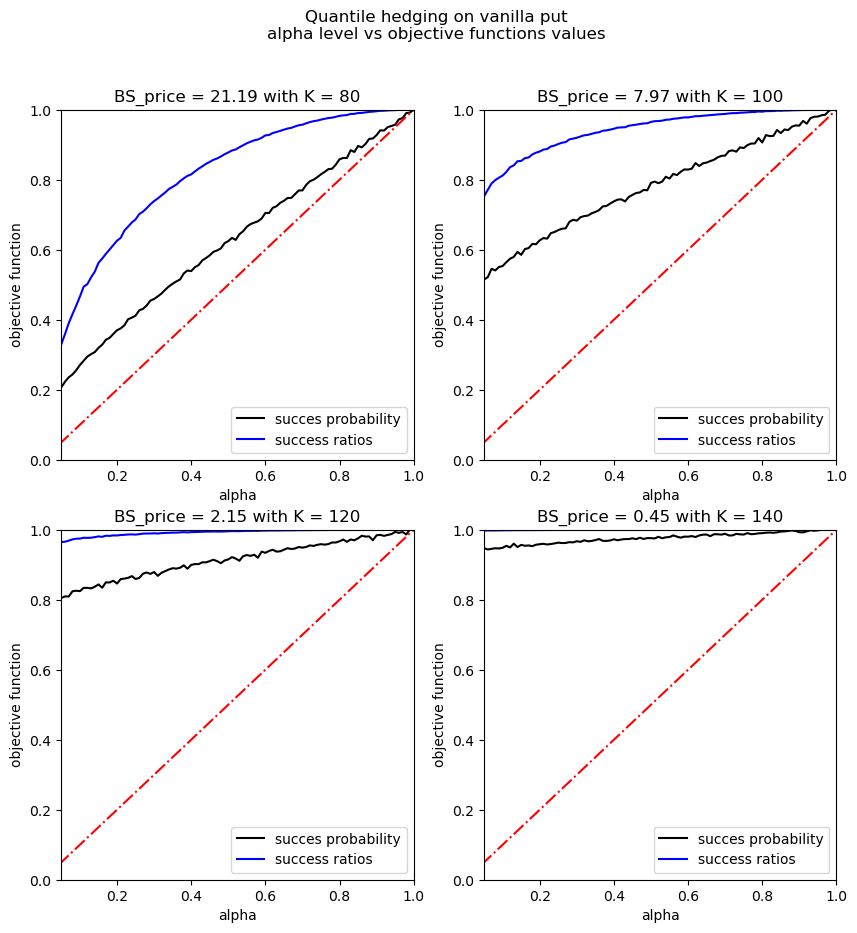

In [56]:
Ks = [80, 100, 120, 140]
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for num, K in tqdm(enumerate(Ks)):
    vanilla_put = Vanilla(underlying, K, T, True)
    BS_price = vanilla_put.get_price(X0, 0)
    alphas = np.arange(5,101,1)/100
    probs = []
    ratios = []
    for a in alphas:
        _, objective_func, _ = payoff_from_v0(vanilla_put, a * BS_price, X0)
        probs.append(objective_func[0])
        ratios.append(objective_func[1])
    axs[num//2, num%2].plot(alphas, probs, color = 'black')
    axs[num//2, num%2].plot(alphas, ratios, color = 'blue')
    axs[num//2, num%2].legend(['succes probability', 'success ratios'])
    axs[num//2, num%2].plot([0,1],[0,1], color = 'red', linestyle='-.')
    axs[num//2, num%2].set_title(f'BS_price = {BS_price:.2f} with K = {K}')
    axs[num//2, num%2].set_xlabel('alpha')
    axs[num//2, num%2].set_ylabel('objective function')
    axs[num//2, num%2].set_xlim([0.05,1])
    axs[num//2, num%2].set_ylim([0,1])
plt.suptitle('Quantile hedging on vanilla put\nalpha level vs objective functions values')

4it [20:30, 307.60s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla put\nfinal simulation values')

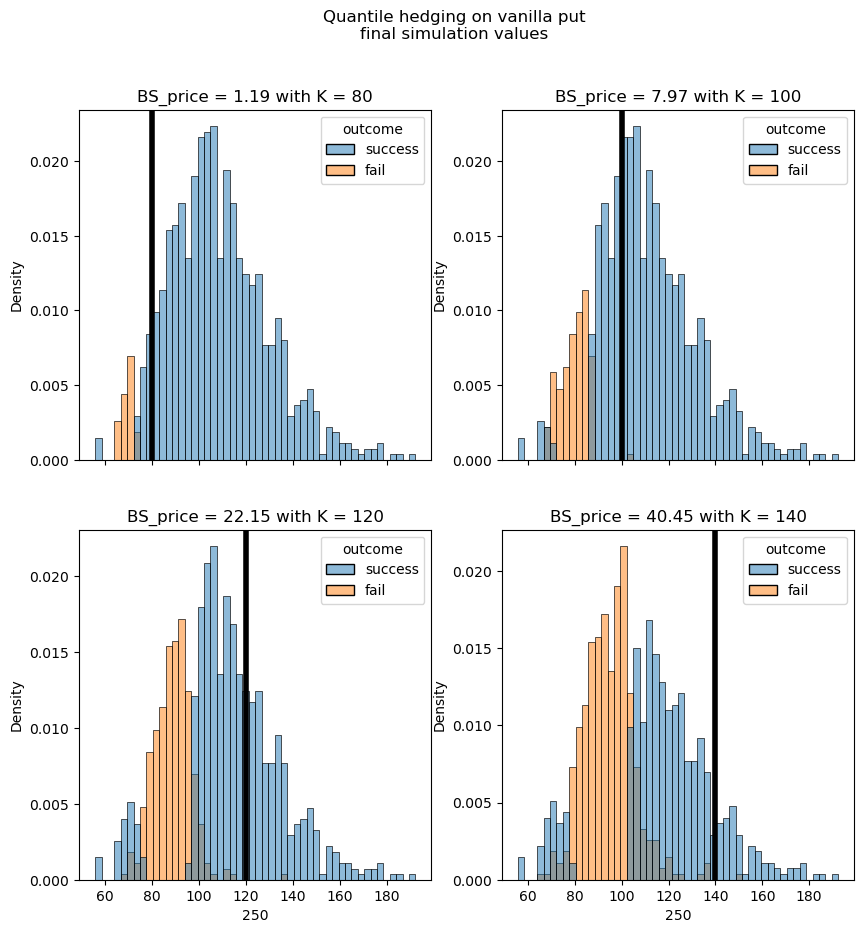

In [57]:
Ks = [80, 100, 120, 140]
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex = True)
for num, K in tqdm(enumerate(Ks)):
    vanilla_put = Vanilla(underlying, K, T, False)
    BS_price = vanilla_put.get_price(X0, 0)
    money_time_put = pd.DataFrame(np.zeros(reality.shape))
    delta_time_put = pd.DataFrame(np.zeros(reality.shape))
    for i in range(repeat):
        trader = Trader(initial_capital = 0.5 * BS_price)
        money, delta, _ = trader.simulate_hedging(vanilla_put, X0*reality.iloc[[i],:], update_freq = 1, mode = 'quantile_traded')
        money_time_put.loc[i] = money
        delta_time_put.loc[i] = delta
    money_time_put_outcome = money_time_put.copy()
    money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
    sb.histplot(ax = axs[num//2, num%2], x = (X0*reality)[underlying.values_per_year * T], hue = money_time_put_outcome['outcome'], bins = 50, stat = 'density').set_title(f'BS_price = {BS_price:.2f} with K = {K}')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla put\nfinal simulation values')

8it [00:11,  1.44s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla put\nmodified payoff')

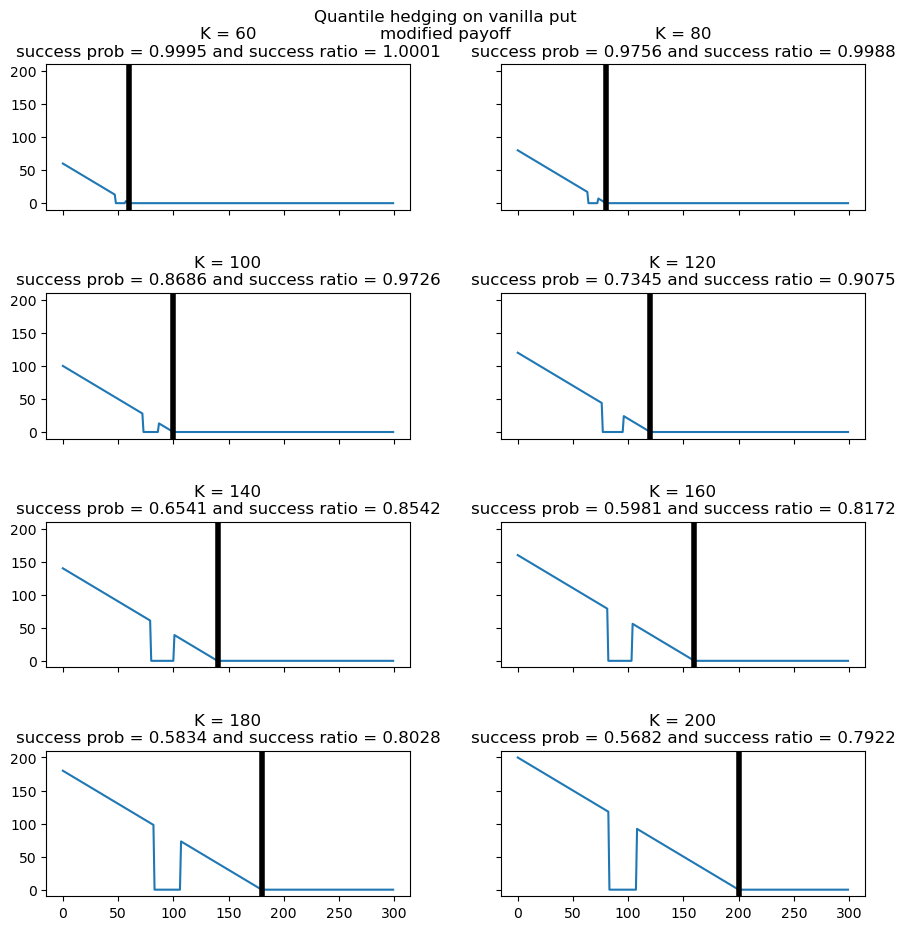

In [58]:
Ks = [60, 80, 100, 120, 140, 160, 180, 200]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharex = True, sharey = True)
fig.tight_layout(pad=5.0)
for num, K in tqdm(enumerate(Ks)):
    vanilla_put = Vanilla(underlying, K, T, False)
    BS_price = vanilla_put.get_price(X0, 0)
    V0 = 0.5 * BS_price
    payoff_func, objective_func, _ = payoff_from_v0(vanilla_put, V0, X0)
    axs[num//2, num%2].plot(X, payoff_func(X))
    axs[num//2, num%2].set_title(f'K = {K}\nsuccess prob = {objective_func[0]:.4f} and success ratio = {objective_func[1]:.4f}')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla put\nmodified payoff')

8it [00:11,  1.45s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla put\nmodified payoff')

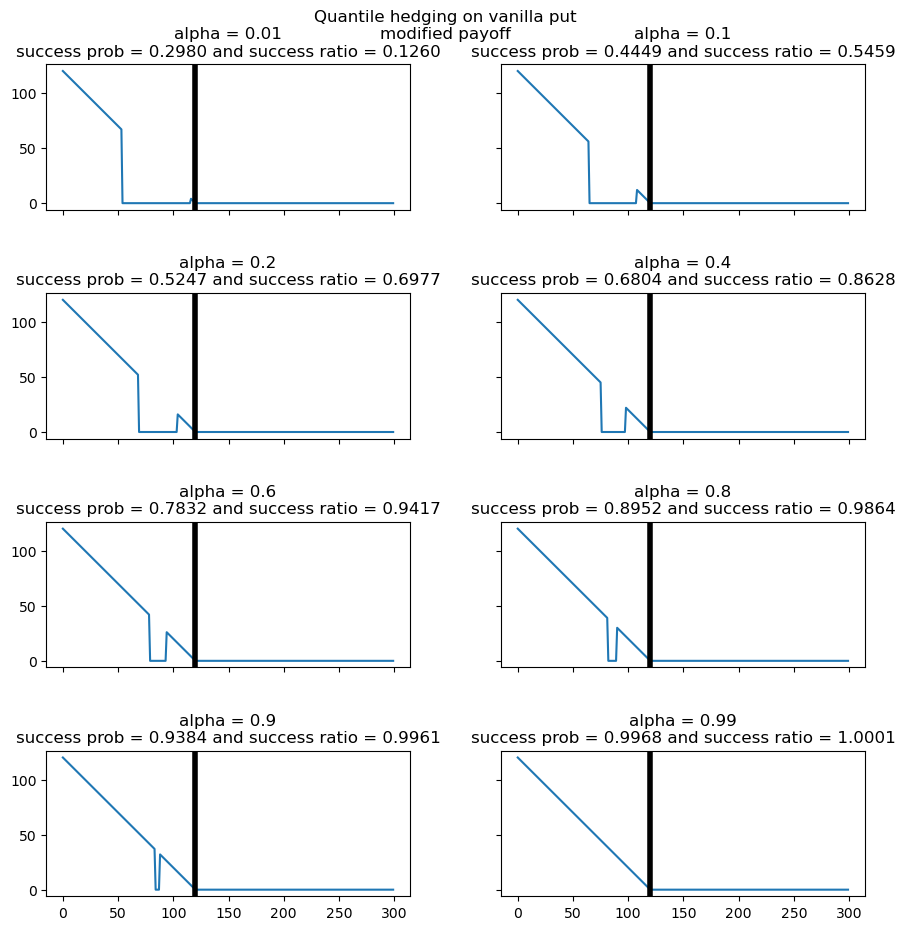

In [59]:
alphas = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharex = True, sharey = True)
fig.tight_layout(pad=5.0)
for num, a in tqdm(enumerate(alphas)):
    vanilla_put = Vanilla(underlying, 120, T, False)
    BS_price = vanilla_put.get_price(X0, 0)
    V0 = a * BS_price
    payoff_func, objective_func, _ = payoff_from_v0(vanilla_put, V0, X0)
    axs[num//2, num%2].plot(X, payoff_func(X))
    axs[num//2, num%2].set_title(f'alpha = {a}\nsuccess prob = {objective_func[0]:.4f} and success ratio = {objective_func[1]:.4f}')
    axs[num//2, num%2].axvline(120, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla put\nmodified payoff')

8it [00:11,  1.41s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla put\nmodified payoff')

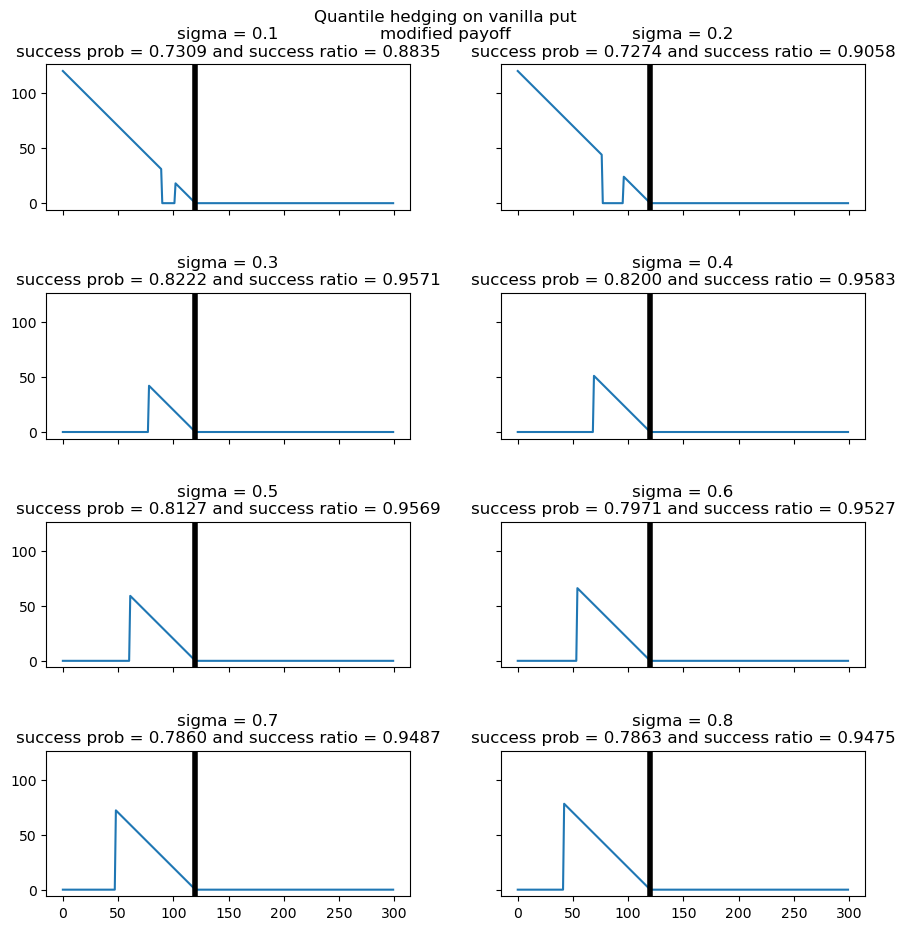

In [60]:
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharex = True, sharey = True)
fig.tight_layout(pad=5.0)
for num, s in tqdm(enumerate(sigmas)):
    underlying = Underlying(mu, s, r, values_per_year)
    vanilla_put = Vanilla(underlying, 120, T, False)
    BS_price = vanilla_put.get_price(X0, 0)
    V0 = BS_price / 2
    payoff_func, objective_func, _ = payoff_from_v0(vanilla_put, V0, X0)
    axs[num//2, num%2].plot(X, payoff_func(X))
    axs[num//2, num%2].set_title(f'sigma = {s}\nsuccess prob = {objective_func[0]:.4f} and success ratio = {objective_func[1]:.4f}')
    axs[num//2, num%2].axvline(120, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla put\nmodified payoff')